In [1]:
import os
import config
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import get_projection_image

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [2]:
data_dir = "../../data/dataset/"
subjects = os.listdir(data_dir)


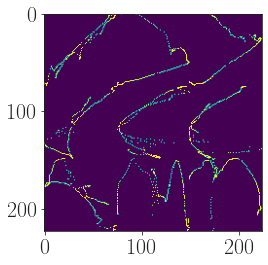

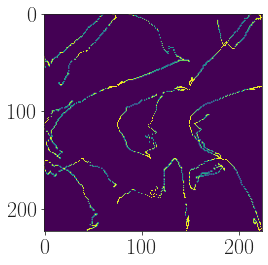

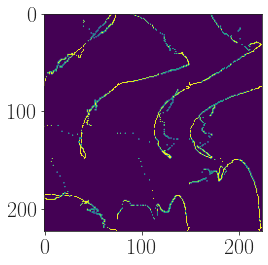

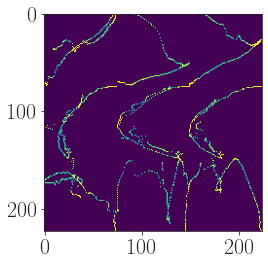

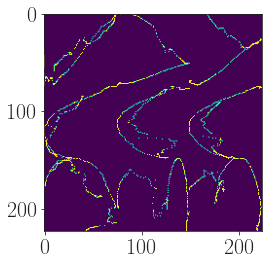

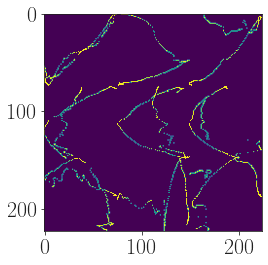

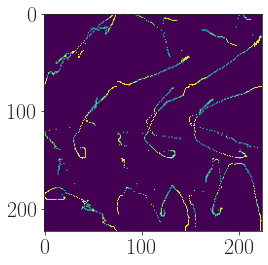

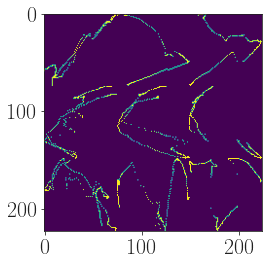

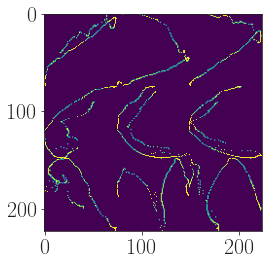

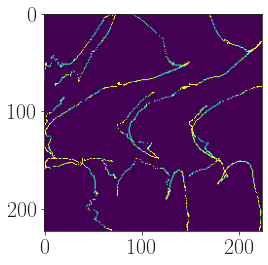

In [16]:
images = []
labels = []

for subject in subjects:
    for gesture in config.GESTURES:
        gesture_dir = os.path.join(data_dir, subject, gesture)
        recordings = os.listdir(gesture_dir)
        for recording in recordings:
            file_path = os.path.join(gesture_dir, recording)

            data = pd.read_csv(file_path)
            data.drop(columns=["time"], inplace=True)
            data.drop(0, inplace=True)  # Remove first All-0 row

            img = get_projection_image(
                data=data,
                img_len=config.IMG_LEN
            )

            plt.imshow(img)
            plt.show()
            # plt.savefig("../assets/projection_demo.pdf")

            images.append(img)
            labels.append(config.GESTURES.index(gesture))

            # break
        break
    break


In [4]:
X = np.array(images, dtype="uint8")
X = np.repeat(np.expand_dims(X, axis=-1), 3, axis=-1)
y = np.array(labels, dtype="uint8")

In [5]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

2022-06-12 19:55:56.577258: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)


In [7]:
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input
base_model = tf.keras.applications.ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(len(config.GESTURES))


2022-06-12 19:55:57.828215: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-12 19:55:57.828247: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: Andromeda
2022-06-12 19:55:57.828251: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: Andromeda
2022-06-12 19:55:57.828397: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.73.5
2022-06-12 19:55:57.828413: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.73.5
2022-06-12 19:55:57.828416: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.73.5
2022-06-12 19:55:57.828657: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions i

94668760/94668760 [==============================] - 10s 0us/step


In [8]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [9]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=config.LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


In [10]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=30,
        restore_best_weights=True
    )
]

history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=300,
    verbose=1,
    callbacks=callbacks
)


Epoch 1/300
4/4 [==============================] - 8s 2s/step - loss: 3.2289 - accuracy: 0.0796 - val_loss: 2.7287 - val_accuracy: 0.1579
Epoch 2/300
4/4 [==============================] - 6s 2s/step - loss: 2.8382 - accuracy: 0.1416 - val_loss: 2.6215 - val_accuracy: 0.2105
Epoch 3/300
4/4 [==============================] - 8s 2s/step - loss: 2.6062 - accuracy: 0.1770 - val_loss: 2.4748 - val_accuracy: 0.2982
Epoch 4/300
4/4 [==============================] - 8s 2s/step - loss: 2.4462 - accuracy: 0.1770 - val_loss: 2.3119 - val_accuracy: 0.3860
Epoch 5/300
4/4 [==============================] - 8s 2s/step - loss: 2.2427 - accuracy: 0.3009 - val_loss: 2.1796 - val_accuracy: 0.4211
Epoch 6/300
4/4 [==============================] - 8s 2s/step - loss: 1.9222 - accuracy: 0.3805 - val_loss: 2.0547 - val_accuracy: 0.4386
Epoch 7/300
4/4 [==============================] - 8s 2s/step - loss: 1.9182 - accuracy: 0.4159 - val_loss: 1.9372 - val_accuracy: 0.5439
Epoch 8/300
4/4 [=================

In [11]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 2s 1s/step - loss: 0.7760 - accuracy: 0.8596


[0.7760432958602905, 0.859649121761322]

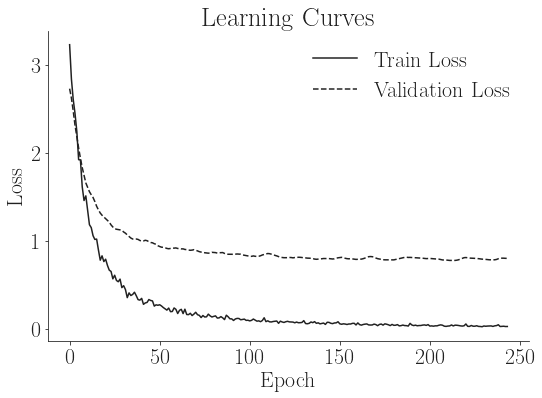

In [15]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 22,
    "text.color": "#212121",
    "axes.edgecolor": "#212121",
    "xtick.color": "#212121",
    "ytick.color": "#212121",
    "axes.labelcolor": "#212121",
    'legend.frameon': False,
})

fig = plt.figure(figsize=(8, 6))
ax = fig.gca()
ax.plot(history.history["loss"], "-", color="#212121", label="Train Loss")
ax.plot(history.history["val_loss"], "--",
        color="#212121", label="Validation Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title("Learning Curves")
plt.legend()
plt.tight_layout()
plt.savefig("../assets/lc.png")
plt.show()


In [13]:
tf.keras.backend.clear_session()
